# Plot of the inferred velocities vs. the directly calculated ones.

In [1]:
%matplotlib inline

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from matplotlib import gridspec

import kepler_kinematics as kek
from scipy.stats import multivariate_normal
import scipy.stats as sps

from tqdm import trange

plotpar = {'axes.labelsize': 16,
           'font.size': 22,
           'legend.fontsize': 15,
           'xtick.labelsize': 10,
           'ytick.labelsize': 10,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [3]:
df = pd.read_csv("../data/data.csv")

In [4]:
results = pd.read_csv("../data/edr3_all.csv")

In [5]:
adf = pd.merge(df, results, on="kepid", how="right")

Calculate velocities with RV set to zero.

In [18]:
vx_rv_zero, vy_rv_zero, vz_rv_zero = [np.zeros(len(adf)) for i in range(3)]
for i in trange(len(adf)):
    xyz, vxyz = kek.simple_calc_vxyz(adf.ra.values[i], adf.dec.values[i],
                                     adf.r_med_photogeo.values[i]*1e-3, adf.pmra.values[i],
                                     adf.pmdec.values[i],
                                     0)
                                     # adf.rv.values[i])
    _vx, _vy, _vz = vxyz
    vx_rv_zero[i], vy_rv_zero[i], vz_rv_zero[i] = _vx.value, _vy.value, _vz.value
    
adf["vx_rv_zero"] = vx_rv_zero
adf["vy_rv_zero"] = vy_rv_zero
adf["vz_rv_zero"] = vz_rv_zero

100%|██████████| 6256/6256 [00:45<00:00, 137.70it/s]


In [11]:
# [key for key in adf.keys()]

In [6]:
def resid_plot(vx, vy, vz, vx_inferred, vy_inferred, vz_inferred, vx_inferred_err, vy_inferred_err, vz_inferred_err,
               lndistance_inferred_err, r_est, lndistance_inferred,
               ms=3, alpha=.1, box_size=120):

    fig = plt.figure(figsize=(16, 6), dpi=200)
    gs = gridspec.GridSpec(2, 4, hspace=.0, wspace=.4, height_ratios=[1, 1])

    ax0 = plt.subplot(gs[0, 0])
    xlims = (np.median(vx) - box_size, np.median(vx_inferred) + box_size)
    ax0.plot(vx, vx_inferred, "k.", ms=ms, alpha=alpha, rasterized=True, zorder=0)
    xs = np.linspace(xlims[0], xlims[1], 100)
    plt.plot(xs, xs, "k", ls="--", zorder=1)
    ax0.set_ylim(xlims)
    ax0.set_xlim(xlims)
    ax0.set_ylabel("$\mathrm{V_x~inferred~[kms^{-1}]}$")
    ax0.set_xticklabels([])

    ax1 = plt.subplot(gs[0, 1])
    ylims = (np.median(vy) - box_size, np.median(vy_inferred) + box_size)
    ax1.plot(vy, vy_inferred, "k.", ms=ms, alpha=alpha, rasterized=True, zorder=0)
    xs = np.linspace(ylims[0], ylims[1], 100)
    plt.plot(xs, xs, "k", ls="--", zorder=1)
    ax1.set_xlim(ylims)
    ax1.set_ylim(ylims)
    ax1.set_ylabel("$\mathrm{V_y~inferred~[kms^{-1}]}$")
    ax1.set_xticklabels([])

    ax2 = plt.subplot(gs[0, 2])
    zlims = (np.median(vz) - box_size, np.median(vz_inferred) + box_size)
    ax2.plot(vz, vz_inferred, "k.", ms=ms, alpha=alpha, rasterized=True, zorder=0)
    xs = np.linspace(zlims[0], zlims[1], 100)
    plt.plot(xs, xs, "k", ls="--", zorder=1)
    ax2.set_xlim(zlims)
    ax2.set_ylim(zlims)
    ax2.set_ylabel("$\mathrm{V_z~inferred~[kms^{-1}]}$");
    ax2.set_xticklabels([])

    ax6 = plt.subplot(gs[0, 3])
    ax6.plot(r_est, lndistance_inferred, "k.", ms=ms+2, mec="none", alpha=alpha, rasterized=True, zorder=0)
    xs = np.linspace(0, 10, 100)
    ax6.plot(xs, xs, "k", ls="--", zorder=1)
    ax6.set_xlim(0, 10)
    ax6.set_ylim(0, 10)
    ax6.set_ylabel("$\mathrm{Distance~inferred~[kpc]}$")
    ax6.set_xticklabels([])
    
    # Residual panels
    # ---------------------------------------------------------------------------------------------------

    ax3 = plt.subplot(gs[1, 0])
    ax3.plot(vx, vx_inferred - vx, "k.", ms=ms+2, mec="none", alpha=alpha, rasterized=True, zorder=0)
    ax3.errorbar(np.median(vx - 40), -30, yerr=np.median(vx_inferred_err), fmt="k.", ms=4, label="$\mathrm{Typical~uncertainty}$")
    ax3.axhline(0, color="k", ls="--", zorder=1)
    ax3.set_ylim(-box_size, box_size)
    ax3.set_xlim(xlims)
    ax3.set_xlabel("$\mathrm{V_x~true~[kms^{-1}]}$")
    ax3.set_ylabel("$\mathrm{Inferred-True~[kms^{-1}]}$")
    ax3.legend(fontsize=13)

    ax4 = plt.subplot(gs[1, 1])
    ax4.plot(vy, vy_inferred-vy, "k.", ms=ms+2, mec="none", alpha=alpha, rasterized=True, zorder=0)
    ax4.errorbar(np.median(vy - 40), -30, yerr=np.median(vy_inferred_err), fmt="k.", ms=4)
    ax4.axhline(0, color="k", ls="--", zorder=1)
    ax4.set_ylim(-box_size, box_size)
    ax4.set_xlim(ylims)
    ax4.set_xlabel("$\mathrm{V_y~true~[kms^{-1}]}$")
    ax4.set_ylabel("$\mathrm{Inferred-True~[kms^{-1}]}$")

    ax5 = plt.subplot(gs[1, 2])
    ax5.plot(vz, vz_inferred - vz, "k.", ms=ms+2, mec="none", alpha=alpha, rasterized=True, zorder=0)
    ax5.errorbar(np.median(vz - 40), -30, yerr=np.median(vz_inferred_err), fmt="k.", ms=4)
    print("typical vz uncertainty = ", np.median(vz_inferred_err), np.median(vz_inferred_err/vz)*100)
    ax5.axhline(0, color="k", ls="--", zorder=1)
    ax5.set_ylim(-box_size, box_size)
    ax5.set_xlim(zlims)
    ax5.set_xlabel("$\mathrm{V_z~true~[kms^{-1}]}$")
    ax5.set_ylabel("$\mathrm{Inferred-True~[kms^{-1}]}$")

    ax7 = plt.subplot(gs[1, 3])
    ax7.plot(r_est, lndistance_inferred-r_est, "k.", ms=ms+2, mec="none", alpha=alpha, rasterized=True, zorder=0)
    ax7.errorbar(0, -.1, yerr=np.median(lndistance_inferred_err), fmt="k.", ms=4)
    ax7.axhline(0, color="k", ls="--", zorder=1)
    ax7.set_ylim(-.5, .5)
    ax7.set_xlabel("$\mathrm{Distance~true~[kpc]}$")
    ax7.set_ylabel("$\mathrm{Inferred-True~[kpc]}$")
        
    return fig

typical vz uncertainty =  4.134654713250277 -5.376933690795567


/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  from ipykernel import kernelapp as app


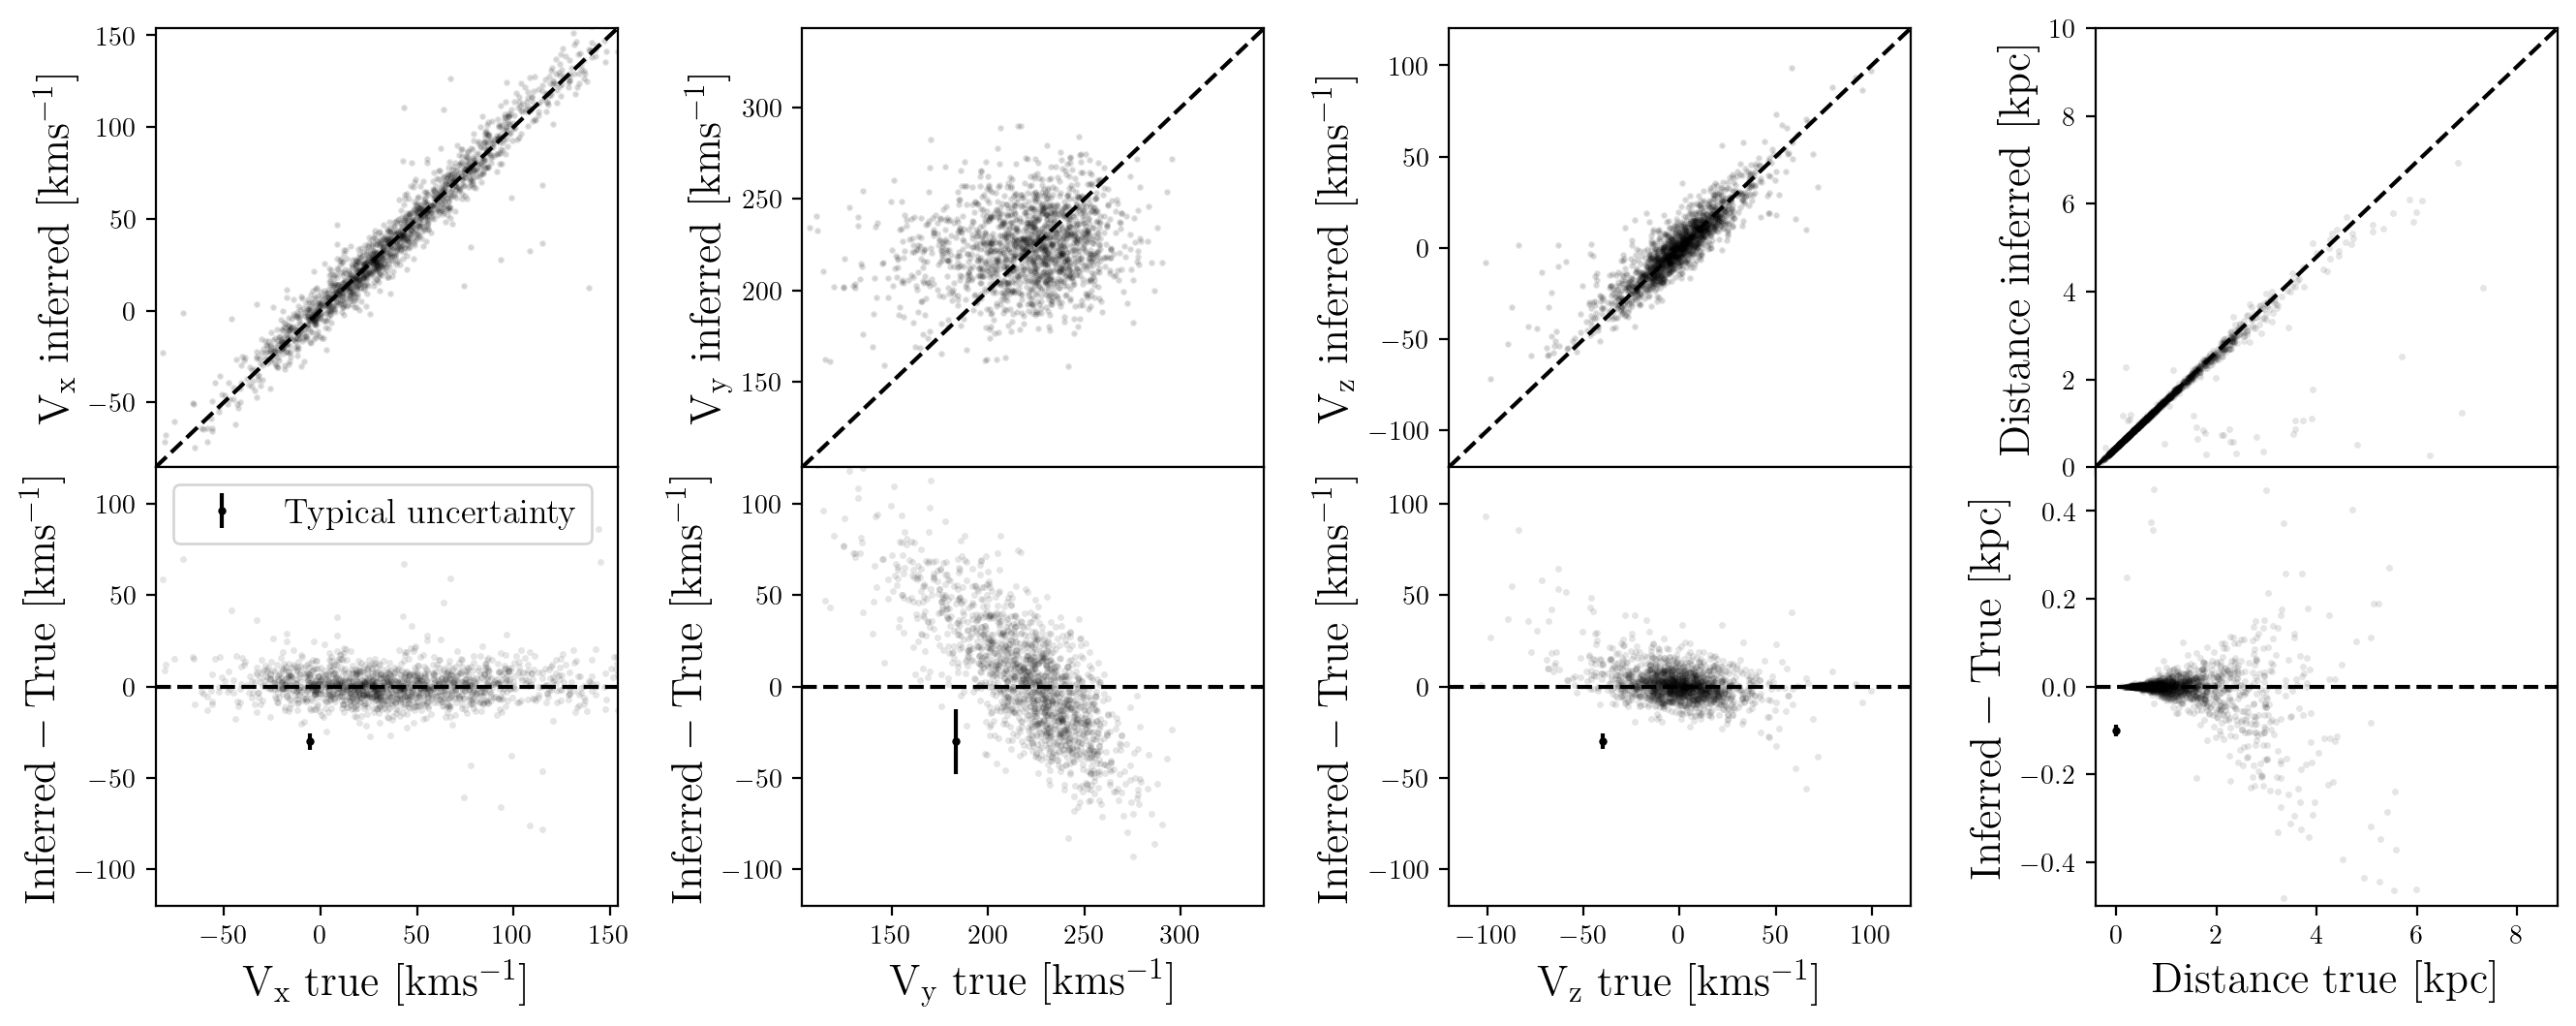

In [7]:
m = np.isfinite(adf.vx.values) & np.isfinite(adf.vy.values) & np.isfinite(adf.vz.values)
m &= np.isfinite(adf.vx_random.values) & np.isfinite(adf.vy_random.values) & np.isfinite(adf.vz_random.values) \
    & np.isfinite(adf.lndistance_random.values)

fig = resid_plot(adf.vx.values[m], adf.vy.values[m], adf.vz.values[m], adf.vx_random.values[m],
                 adf.vy_random.values[m], adf.vz_random.values[m],
                 adf.vx_inferred_err.values[m], adf.vy_inferred_err.values[m], adf.vz_inferred_err.values[m],
                 adf.lndistance_inferred_err.values[m],
                 adf.r_med_photogeo.values[m]*1e-3, np.exp(adf.lndistance_random.values[m]))

plt.tight_layout()

typical vz uncertainty =  4.134654713250277 -5.376933690795567


/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  # This is added back by InteractiveShellApp.init_path()


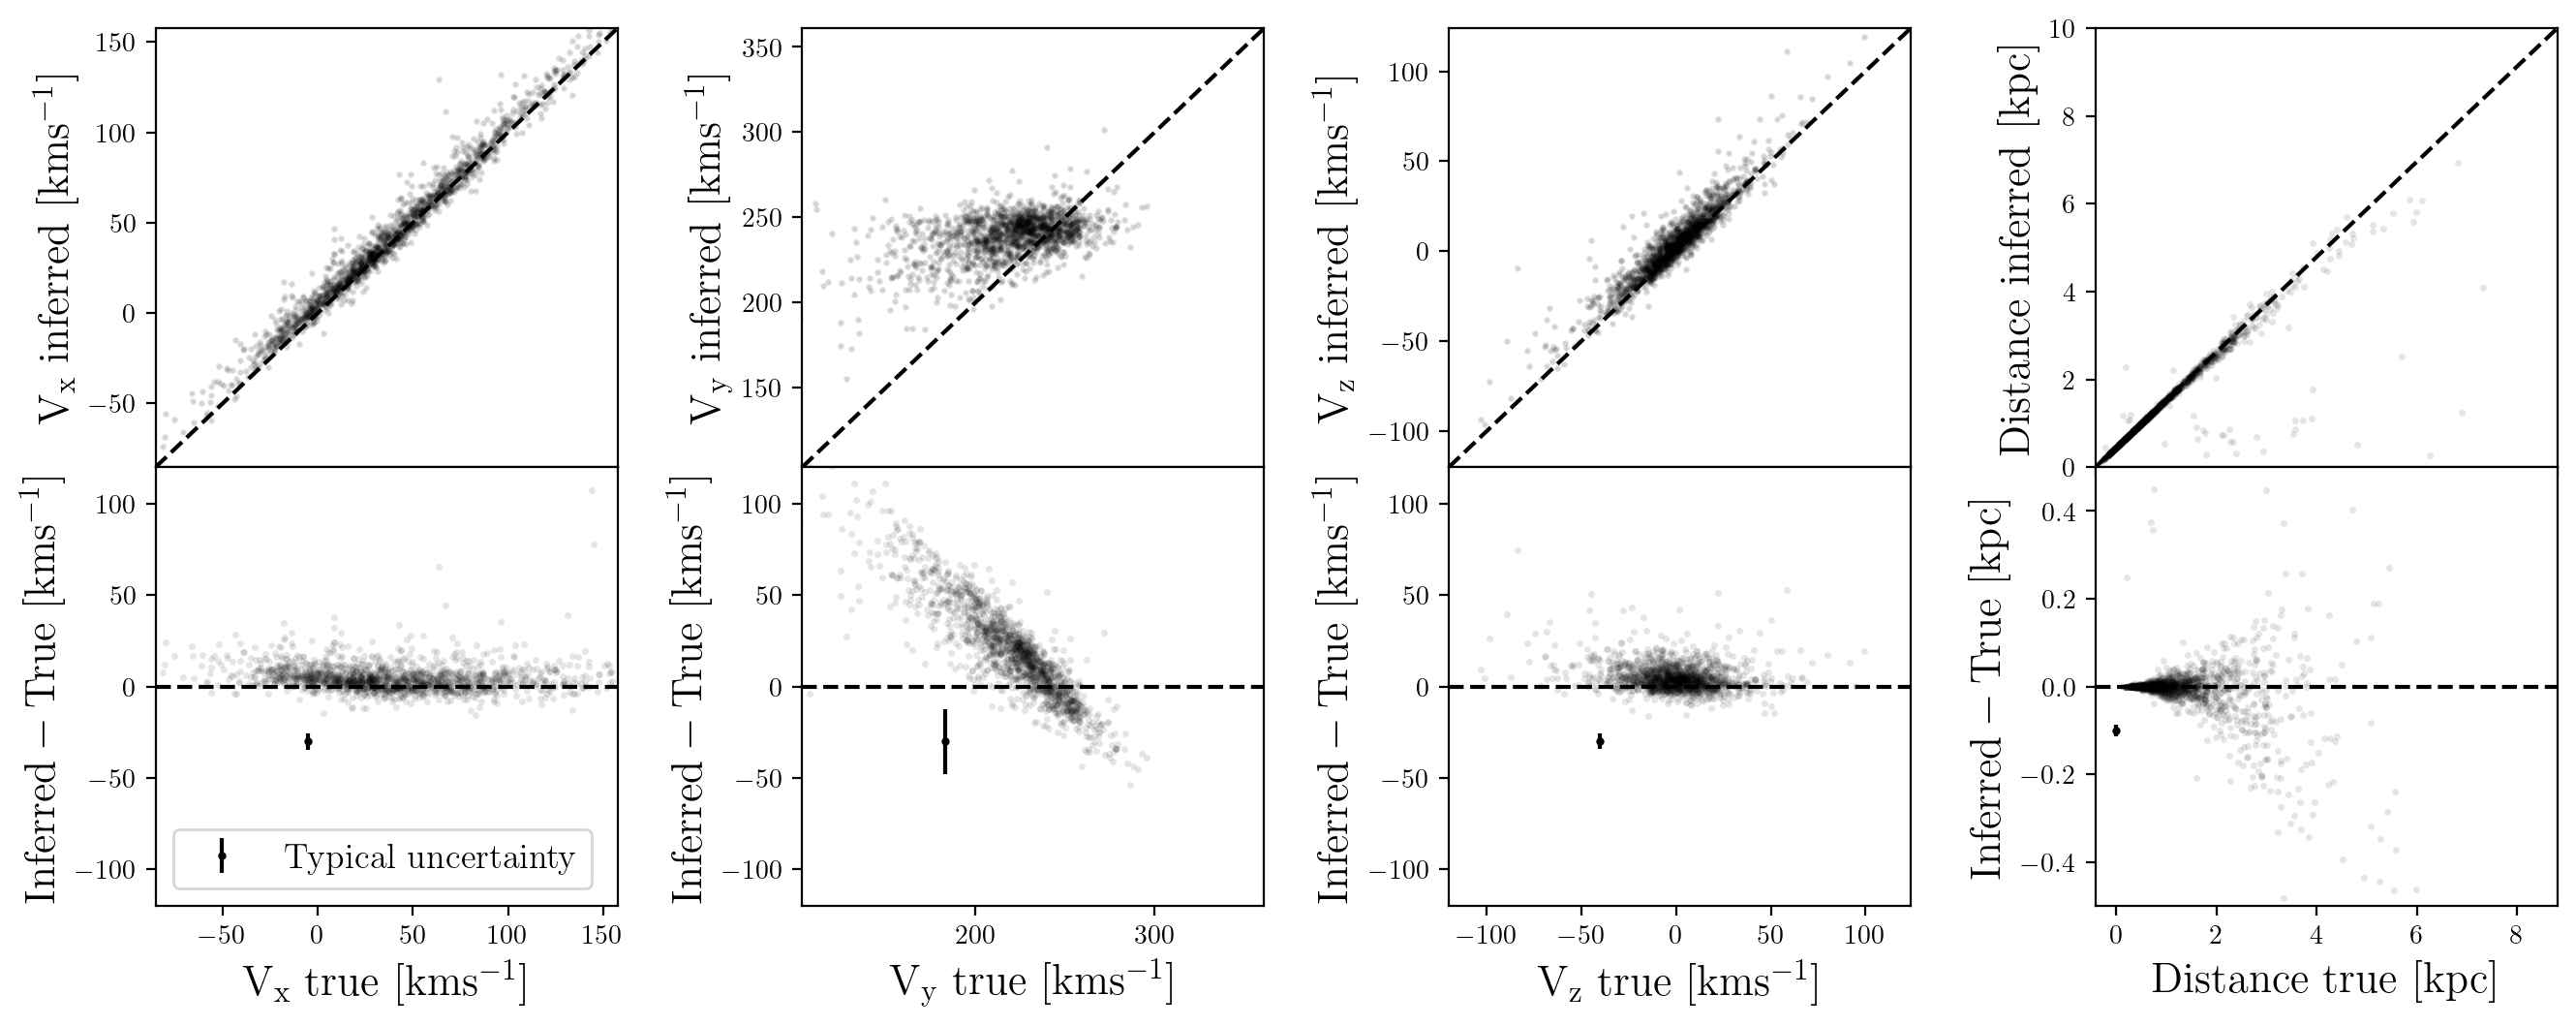

In [19]:
m = np.isfinite(adf.vx.values) & np.isfinite(adf.vy.values) & np.isfinite(adf.vz.values)
m &= np.isfinite(adf.vx_random.values) & np.isfinite(adf.vy_random.values) & np.isfinite(adf.vz_random.values) \
    & np.isfinite(adf.lndistance_random.values)

fig = resid_plot(adf.vx.values[m], adf.vy.values[m], adf.vz.values[m], adf.vx_rv_zero.values[m],
                 adf.vy_rv_zero.values[m], adf.vz_rv_zero.values[m],
                 adf.vx_inferred_err.values[m], adf.vy_inferred_err.values[m], adf.vz_inferred_err.values[m],
                 adf.lndistance_inferred_err.values[m],
                 adf.r_med_photogeo.values[m]*1e-3, np.exp(adf.lndistance_random.values[m]))

plt.tight_layout()

In [30]:
def gauss(x, mu, sig, amp=1.):
    return amp/(sig * np.sqrt(2 * np.pi)) * np.exp(-.5 * (x - mu)**2 / sig**2)

In [46]:
def kde(v, xlim):
    kernel = sps.gaussian_kde(v)
    xs = np.linspace(xlim[0], xlim[1], 1000)
    return xs, kernel(xs)

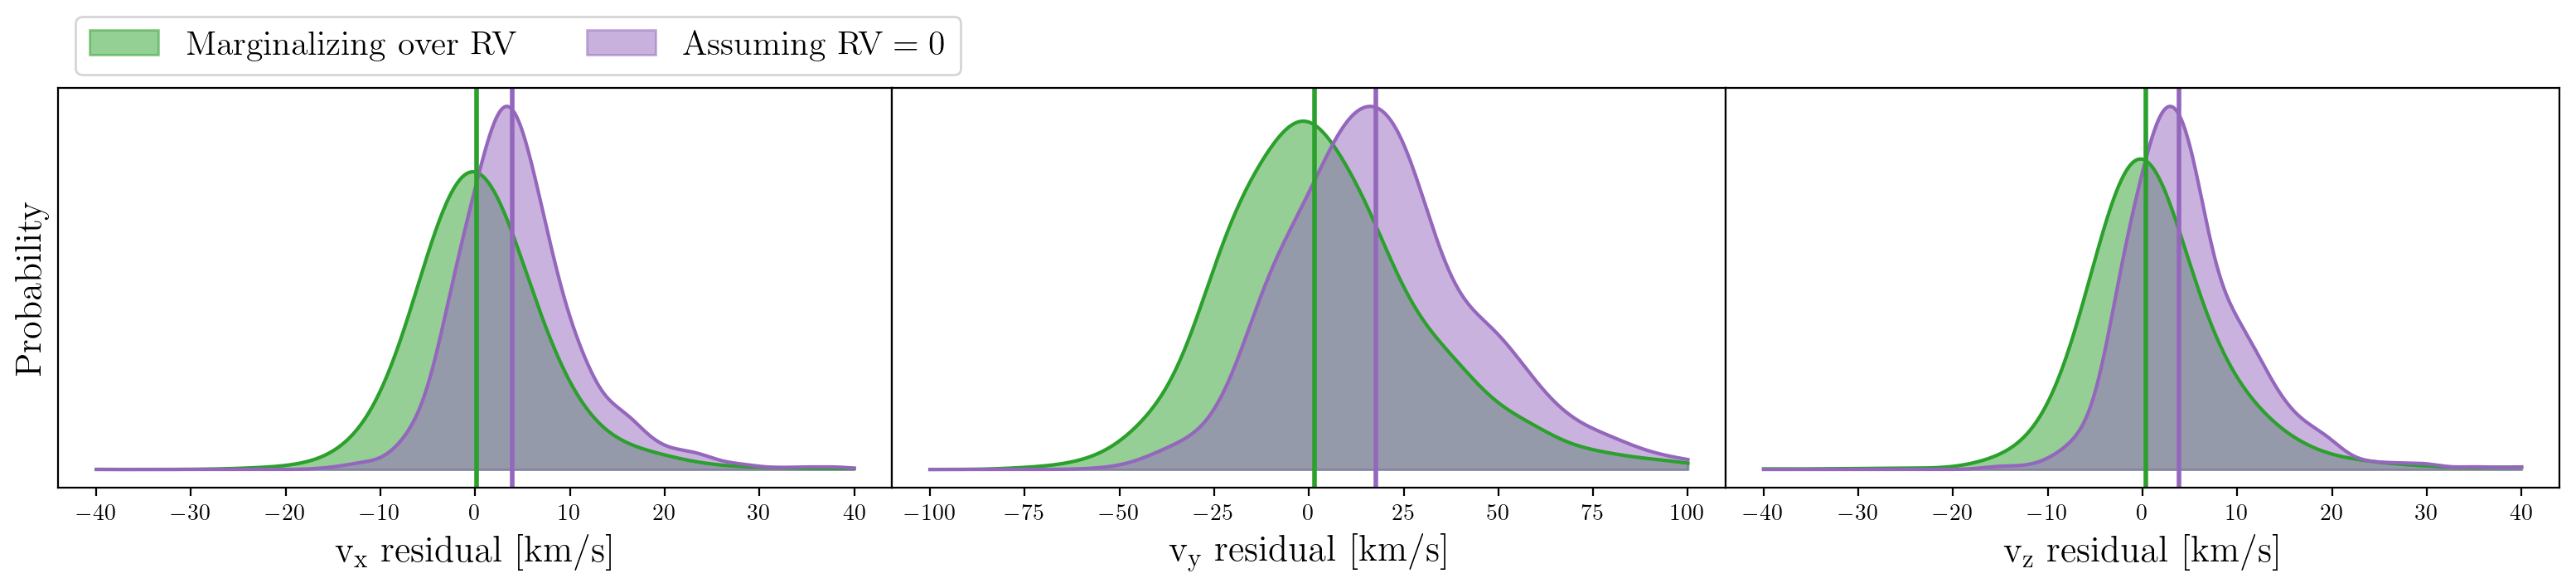

In [89]:
f = np.isfinite(adf.vx_inferred) & np.isfinite(adf.vx_rv_zero) & np.isfinite(adf.vx)

c0 = "C2"
c1 = "C4"

fig = plt.figure(figsize=(16, 4), dpi=200)

ax0 = fig.add_subplot(131)
xs, k = kde(adf.vx_inferred[f]-adf.vx[f], [-40, 40])
ax0.plot(xs, k, color=c0);
ax0.fill_between(xs, np.zeros(len(k)), k, color=c0, alpha=.5, label="$\mathrm{Marginalizing~over~RV}$");
xs, k = kde(adf.vx_rv_zero[f]-adf.vx[f], [-40, 40])
ax0.plot(xs, k, color=c1);
ax0.fill_between(xs, np.zeros(len(k)), k, color=c1, alpha=.5, label="$\mathrm{Assuming~RV=0}$");

ax0.legend(bbox_to_anchor=(0., .99, 1., .102), ncol=2);
# plt.legend(bbox_to_anchor=(0., .92, 1., .102), loc=3, 
#     ncol=6, mode="expand", borderaxespad=0.,
#     framealpha=.999)

ax0.set_xlabel("$\mathrm{v_x~residual~[km/s]}$");
ax0.set_ylabel("$\mathrm{Probability}$");

ax0.axvline(np.median(adf.vx_inferred.values[f]-adf.vx.values[f]), color=c0, lw=2)
ax0.axvline(np.median(adf.vx_rv_zero.values[f]-adf.vx.values[f]), color=c1, lw=2)

ax0.set_yticklabels([])
ax0.set_yticks([])

#----------------------------------------------------------------------------------

f = np.isfinite(adf.vy_inferred) & np.isfinite(adf.vy_rv_zero) & np.isfinite(adf.vy)

ax1 = fig.add_subplot(132)
xs, k = kde(adf.vy_inferred[f]-adf.vy[f], [-100, 100])
ax1.plot(xs, k, color=c0);
ax1.fill_between(xs, np.zeros(len(k)), k, color=c0, alpha=.5);
xs, k = kde(adf.vy_rv_zero[f]-adf.vy[f], [-100, 100])
ax1.plot(xs, k, color=c1);
ax1.fill_between(xs, np.zeros(len(k)), k, color=c1, alpha=.5);

ax1.set_xlabel("$\mathrm{v_y~residual~[km/s]}$");

ax1.axvline(np.median(adf.vy_inferred.values[f]-adf.vy.values[f]), color=c0, lw=2)
ax1.axvline(np.median(adf.vy_rv_zero.values[f]-adf.vy.values[f]), color=c1, lw=2)

ax1.set_yticklabels([])
ax1.set_yticks([])

#----------------------------------------------------------------------------------

f = np.isfinite(adf.vz_inferred) & np.isfinite(adf.vz_rv_zero) & np.isfinite(adf.vz)

ax2 = fig.add_subplot(133)
xs, k = kde(adf.vz_inferred[f]-adf.vz[f], [-40, 40])
ax2.plot(xs, k, color=c0);
ax2.fill_between(xs, np.zeros(len(k)), k, color=c0, alpha=.5);
xs, k = kde(adf.vz_rv_zero[f]-adf.vz[f], [-40, 40])
ax2.plot(xs, k, color=c1);
ax2.fill_between(xs, np.zeros(len(k)), k, color=c1, alpha=.5);

ax2.set_xlabel("$\mathrm{v_z~residual~[km/s]}$");

ax2.axvline(np.median(adf.vz_inferred.values[f]-adf.vz.values[f]), color=c0, lw=2)
ax2.axvline(np.median(adf.vz_rv_zero.values[f]-adf.vz.values[f]), color=c1, lw=2)

ax2.set_yticklabels([])
ax2.set_yticks([])

plt.tight_layout()
plt.subplots_adjust(wspace=0)

plt.savefig("../plots/inferred_vs_calc")
plt.savefig("../paper/inferred_vs_calc.pdf")